# Decomposition-Residuals Neural Networks: Hybrid system identification applied to electricity forecasting

### Konstantinos Theodorakos
##### Ph.D. student
#### KU Leuven, Belgium
konstantinos.theodorakos@esat.kuleuven.be
##### Dept. of Electrical Engineering (ESAT) – Research Group STADIUS, Center for Dynamical Systems, Signal Processing, and Data Analytics

Code adapted from: https://www.tensorflow.org/tutorials/structured_data/time_series

## Imports:

In [1]:
import os
import sys
import gc
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import torch
from layers.DataframeDecompositionLayer import DataframeDecompositionLayer

## Settings:

In [2]:
do_DecompositionResiduals = False # DR-DNN or plain DNN
cpu_only = False # CPU or GPU acceleration
do_extras = False # Extras: 3 STD outliers, Day/year sines,
MAX_EPOCHS = 150 # 300 # 500 # 350 # 150 # 20
stop_early_patience = 8
reduce_learning_rate_patience = 5
min_learning_rate_on_plateau= 1e-4
window_stride = 1 # 12 # 24 # 1 # hours
use_stl = True # False for ablation study
use_moving_filters = True # False for ablation study
use_extra_filters = True # False for default DR-DNN

ablation_text = ""
if use_stl == False or use_moving_filters == False:
    use_ablation = True
    if use_stl:
        ablation_text = "_no_moving_filters"
    else:
        ablation_text = "_no_STL"
else:
    use_ablation = False


## Parameters:

In [3]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
seed = 0

## Data:

In [4]:
df = pd.read_excel("data/ActualsAll_8PM.xlsx") # Read from excel

df.index = pd.to_datetime(df.pop('Time'))

# df = df.head(int(365 * 24 * 2.5)).copy() # Pre-COVID: first 2.5 years
# df = df.tail(int(365 * 24 * 2)).copy() # Post-COVID: last 2 years
# df = df.tail(24 * 30)  # A few samples for quick testing
print(df.shape)
df.tail()

train_ratio = 0.7 # 0.98  # 0.7
validation_ratio = 0.2 # 0.01  # 0.2
test_ratio = 1 - (train_ratio + validation_ratio)
print("Train/validation/test: {}%/{}%/{}%".format(np.round(train_ratio * 100, 3), np.round(validation_ratio * 100, 3), np.round(test_ratio * 100, 3)))

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

(34360, 7)
Train/validation/test: 70.0%/20.0%/10.0%


## Methods:

In [5]:
def get_DR_df(time_series):
    layer_decomposition = DataframeDecompositionLayer(
        forecast_STL=False, freq="H", period=24, return_dataframe=True,
        endogenous_variables=["Load (kW)",
                              # "Temperature (C) "
                              ],
        multiple_lags=True,
        use_stl=use_stl,
        use_moving_filters=use_moving_filters,
        use_extra_filters=use_extra_filters
    )
    out_layer_decomposition = layer_decomposition.get_decomposition(time_series)

    return out_layer_decomposition

## DR:

### Different on each subset:
1. **train**
2. **train+val**
3. **train+val+test** sequence...

#### From the START:
SPLIT data: train, train+val, train+val+test sequence...

#### Then for each subset:

1. Remove 3 STD outliers (optional, affects post-sample).
2. Apply DR (affects post-sample).
3. Feature engineering wind (rolling: not affected post-sample).
4. Add weekly lag (rolling: not affected in-sample).
5. Normalize (on train mean/std) (affects post-sample).

In [6]:
model_type = "No DR"
if do_DecompositionResiduals:

    model_type = "DR-DNN"

    # DR split
    pre_train_df = df[0:int(n*train_ratio)].copy()
    pre_train_val_df = df[0:int(n*(train_ratio + validation_ratio))].copy()
    pre_train_val_test_df = df.copy()

    # Gradual DR fit
    dr_train = get_DR_df(pre_train_df)
    dr_train_val = get_DR_df(pre_train_val_df)
    dr_train_val_test = get_DR_df(pre_train_val_test_df)

    # Replace DR segments of gradual fit: train/val/test
    dr_train_val_test[0:int(n*train_ratio)] = dr_train[0:int(n*train_ratio)]  # Replace with old train decomp
    dr_train_val_test[int(n*train_ratio):int(n*(train_ratio + validation_ratio))] = dr_train_val[int(n*train_ratio):int(n*(train_ratio + validation_ratio))]  # Replace with old val decomp. Test decomp not needed
    df = dr_train_val_test.copy()

date_time = df.index

A few features in time:

(34360, 7)


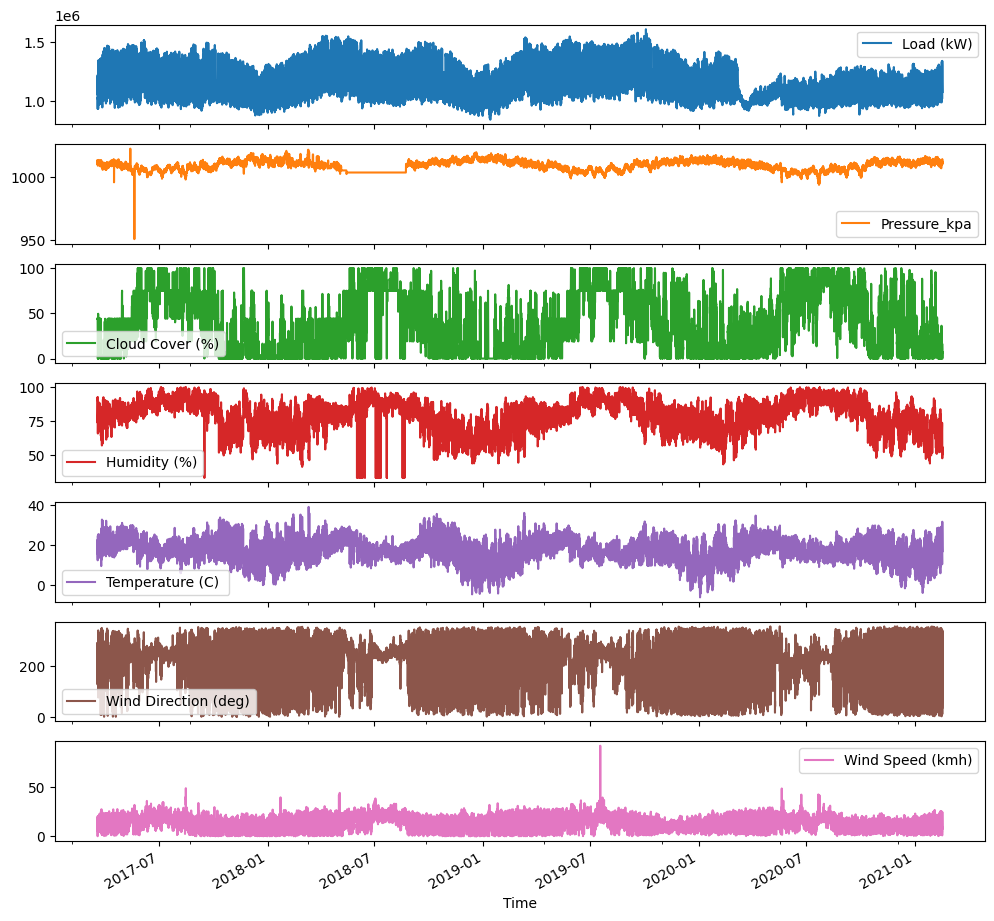

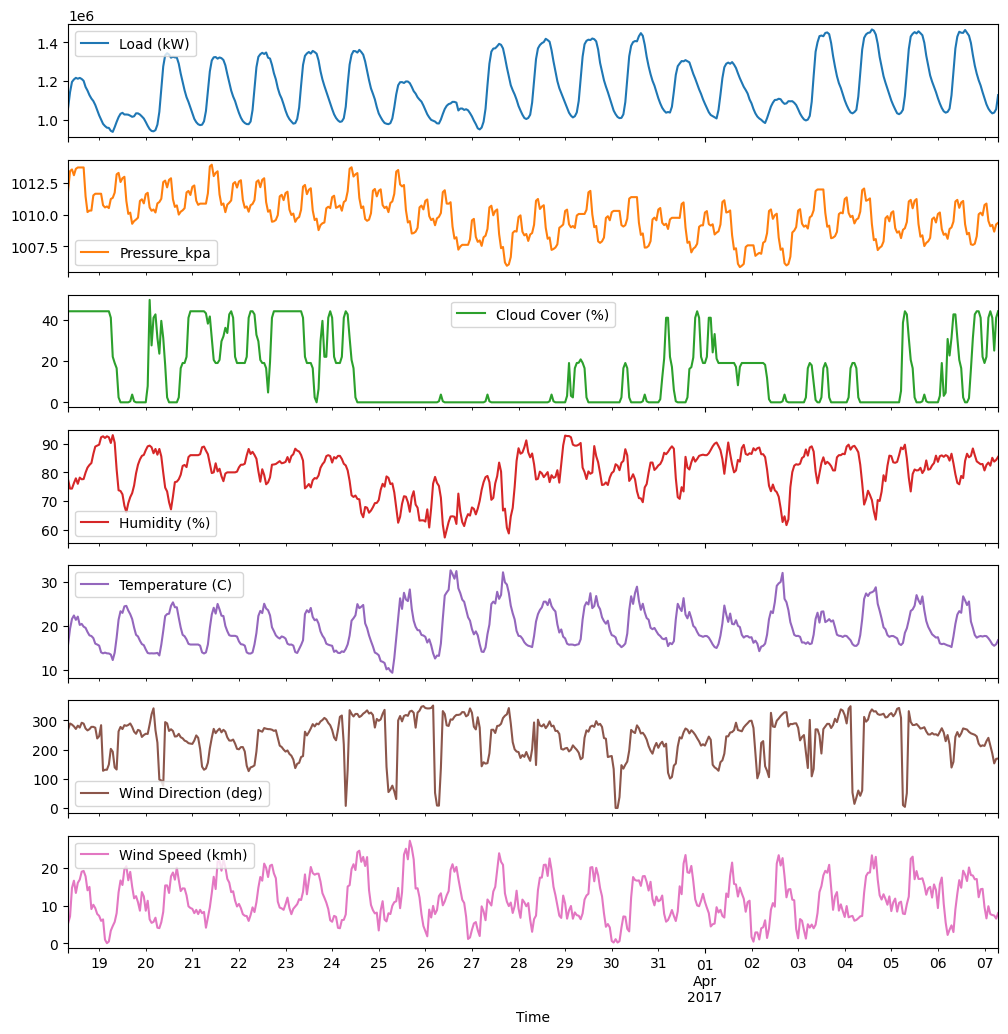

In [7]:
print(df.shape)
df.head()

plot_cols = ['Load (kW)', 'Pressure_kpa', 'Cloud Cover (%)', 'Humidity (%)',
       'Temperature (C) ', 'Wind Direction (deg)', 'Wind Speed (kmh)']

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(12, 12))

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, figsize=(12, 12))

Dataset statistics:

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Load (kW),34360.0,1.148487e+06,148320.957261,845471.358137,1.029711e+06,1.112139e+06,1.249680e+06,1.605192e+06
Pressure_kpa,34360.0,1.009425e+03,3.974070,950.595000,1.006350e+03,1.009925e+03,1.012400e+03,1.022915e+03
Cloud Cover (%),34360.0,3.981531e+01,32.364608,0.000000,8.000000e+00,4.087500e+01,7.450000e+01,1.000000e+02
Humidity (%),34360.0,7.958024e+01,11.339111,33.333333,7.200000e+01,8.141667e+01,8.866667e+01,1.000000e+02
Temperature (C),34360.0,1.673184e+01,5.774698,-6.418114,1.343189e+01,1.668189e+01,2.053189e+01,3.906689e+01
Wind Direction (deg),34360.0,2.094470e+02,94.733169,0.000000,1.257500e+02,2.391250e+02,2.856250e+02,3.575000e+02
Wind Speed (kmh),34360.0,1.268949e+01,6.640257,0.000000,7.646250e+00,1.194250e+01,1.771406e+01,9.149750e+01


## Feature engineering

Wind direction degrees:

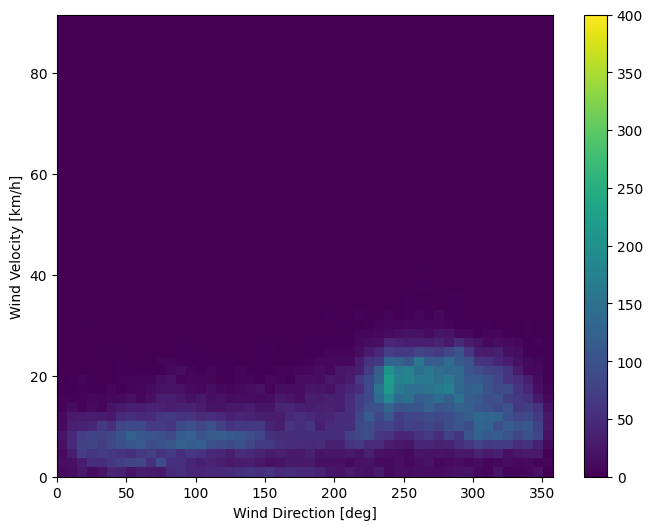

In [9]:
ax = plt.gca()
ax.axis('tight')
plt.hist2d(df['Wind Direction (deg)'], df['Wind Speed (kmh)'],
           bins=(50, 50),
           vmax=400, # linear normalization
)
plt.colorbar()

plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [km/h]')
plt.savefig("pics/wind_direction_velocity.svg")
plt.savefig("pics/wind_direction_velocity.png")

Wind direction degrees to wind vector:

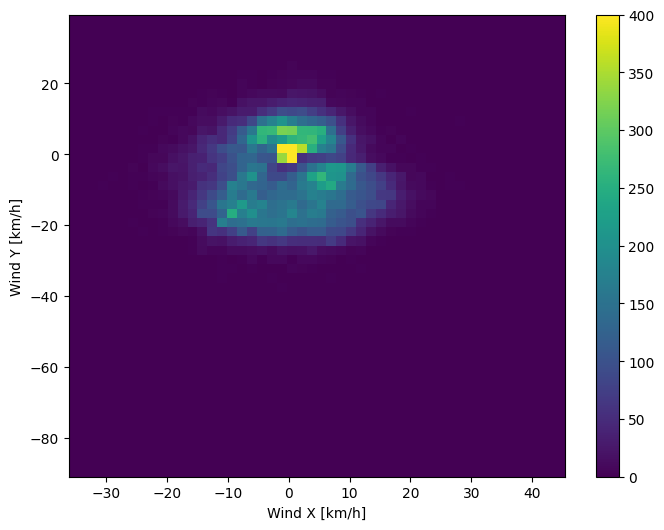

In [10]:
wv = df.pop('Wind Speed (kmh)')
# Convert to radians.
wd_rad = df.pop('Wind Direction (deg)') * np.pi / 180.0
# Calculate the wind x and y components.
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

ax = plt.gca()
ax.axis('tight')
plt.hist2d(df['Wx'], df['Wy'],
              bins=(50, 50),
           vmax=400 # linear normalization
           )
plt.colorbar()
plt.xlabel('Wind X [km/h]')
plt.ylabel('Wind Y [km/h]')

plt.savefig("pics/wind_vectors.svg")
plt.savefig("pics/wind_vectors.png")

Time:

In [11]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [12]:
if do_DecompositionResiduals and do_extras:
    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [13]:
if do_DecompositionResiduals:
    plot_range = 24 * 7

    legend = []
    for column in df.columns:
        if "cos" in column or "sin" in column or "time" in column:
            plt.plot(np.array(df[column])[:plot_range])
            legend.append(column)
    plt.legend(legend)
    plt.xlabel('Time [h]')
    plt.title('Calendar signals (week)')
    plt.savefig("pics/calendar_DR.svg")
    plt.savefig("pics/calendar_DR.png")
    plt.savefig("pics/calendar_DR.pdf")

In [14]:
if do_DecompositionResiduals and do_extras:
    fft = tf.signal.rfft(df['Load (kW)'])
    f_per_dataset = np.arange(0, len(fft))

    n_samples_h = len(df['Load (kW)'])
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    f_per_year = f_per_dataset/years_per_dataset
    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(0, 2.5 * 1e9)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 7, 30, 365.2524/4.0, 365.2524], labels=['1/Year', '1/Quarter-year', '1/month', '1/week', '1/day'])
    _ = plt.xlabel('Frequency (log scale)')

Weekly lag:

In [15]:
df['Load (kW)_lag7d'] = df['Load (kW)'].shift(24*7).bfill()
df['Load (kW)_lag6d'] = df['Load (kW)'].shift(24*6).bfill()
df['Load (kW)_lag5d'] = df['Load (kW)'].shift(24*5).bfill()

Do split the data:

In [16]:
train_df = df[0:int(n*train_ratio)]
val_df = df[int(n*train_ratio):int(n*(train_ratio + validation_ratio))]
test_df = df[int(n*(train_ratio + validation_ratio)):]

num_features = df.shape[1]

# Plot time periods:
print("Train (", train_df.shape[0], "):\n\t", train_df.head(1).index.values, " to ", train_df.tail(1).index.values)
print("Validation (", val_df.shape[0], "):\n\t", val_df.head(1).index.values, " to ", val_df.tail(1).index.values)
print("Test (", test_df.shape[0], "):\n\t", test_df.head(1).index.values, " to ", test_df.tail(1).index.values)

Train ( 24052 ):
	 ['2017-03-18T08:00:00.000000000']  to  ['2019-12-15T11:00:00.000000000']
Validation ( 6871 ):
	 ['2019-12-15T12:00:00.000000000']  to  ['2020-09-26T18:00:00.000000000']
Test ( 3437 ):
	 ['2020-09-26T19:00:00.000000000']  to  ['2021-02-16T23:00:00.090000000']


Normalize the data:

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Feature distributions:

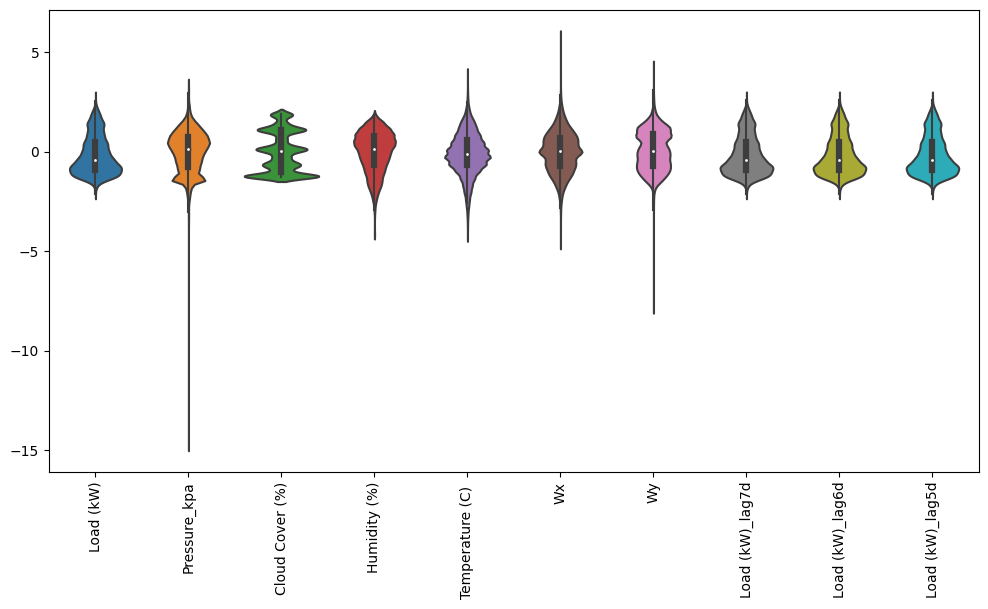

In [18]:
df_std = (df - train_mean) / train_std
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)